In [41]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [42]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)



Running TensorFlow version  2.9.2


In [43]:
'''Trains a simple convnet on the MNIST dataset.


'''



'Trains a simple convnet on the MNIST dataset.\n\n\n'

In [44]:
# Switch to Tensorflow version 1 if you want to run the sections of code that have yet to be converted to Tensorflow 2
#%tensorflow_version 1.x

In [45]:
# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Version 2, minor 9


In [46]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Functional API
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [47]:
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import IPython

# Utility routines

In [48]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

def prepareData(X_train, y_train, X_test, y_test, flatten=True):
  if tf.keras.backend.image_data_format() == 'channels_first':
      X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
      X_test  = X_test.reshape( X_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
      X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

  return input_shape, X_train, y_train, X_test, y_test


In [49]:
def showImage(img, ax=plt, title=None, cmap=None):
  # Some datasets (e.g., MNIST) have only 1 channel instead of 3
  if img.shape[-1] == 1:
    img = img[:,:, 0]
    cmap = "gray"
  
  
  if cmap is None:
    _= ax.imshow(img)
  else:
    _= ax.imshow(img, cmap=cmap)

  if title is not None:
    ax.set_title(title)
    
   
def showTrain(xtrain, ytrain, num=5):
  #  ytrain is OHE
  num_classes = ytrain.shape[-1]

  fig = plt.figure(figsize=(12,12))
  for thisClass in range(0, num_classes):
    xtrain_thisClass = xtrain[ ytrain[:,thisClass] == 1]

    for i in range(0,num):
      ax = fig.add_subplot(num_classes, num, thisClass * num + i +1)
      showImage(xtrain_thisClass[i], ax)

      # ax.set_title(y[i])
      # ax.set_xlabel( idxs[i] )
      ax.set_xticks([])
      ax.set_yticks([])


def trainModel(model, modelName, X_train, y_train, X_test, y_test, batch_size = 128, epochs=20, num_classes=10):
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
              ]   

  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                metrics=['acc']
                )

  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)
  

  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_test, y_test)
            )
  
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return score[1], plotFile

# Get the data, prepare it

In [50]:

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) =  fashion_mnist.load_data()

input_shape, X_train, y_train, X_test, y_test = prepareData(X_train, y_train, X_test, y_test)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

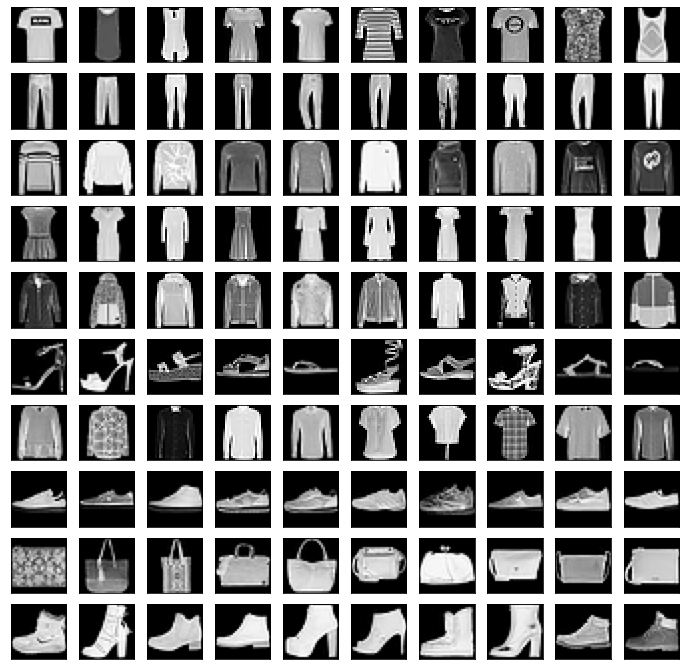

In [51]:
showTrain(X_train, y_train, num=10)

# Routines to create models

In [52]:
def createModelClassifier(input_shape, num_classes=10):
  model = Sequential( [ Flatten(input_shape=input_shape),
                        Dense(num_classes, activation='softmax') 
                        ]
                     )
  return model

def createModel1():
  model = Sequential( [ 
                       Conv2D(32, kernel_size=(3, 3),
                              activation='relu',
                              input_shape=input_shape,
                              padding="same"),
                       Flatten(),
                       Dense(128, activation='relu'),
                       Dropout(0.5),
                       Dense(num_classes, activation='softmax')
  ]
)

  return model

In [53]:
def createModel(input_shape, num_filters=[32], num_classes=10, pool=[], extraDense=False):
  # Create first layer: needs input_spec
  model = Sequential( [ 
                        Conv2D(num_filters[0], kernel_size=(3, 3),
                                activation='relu',
                                input_shape=input_shape,
                                padding="same") 
                        ]
                    )
  
  # Add more Conv/Pooling layers
  for i in range(1, len(num_filters)):   
    if  (len(pool) > i) and pool[i]:
      print("Adding Pool + Conv block with {n:d} filters".format(n=num_filters[i]))
      model.add( MaxPooling2D(pool_size=(2, 2)) )
    else:
      print("Adding Conv block with {n:d} filters".format(n=num_filters[i]))

    model.add( Conv2D(num_filters[i], (3, 3), activation='relu', padding="same"))
    model.add( Dropout(0.25))

  # Add tail
  model.add( Flatten() )

  if extraDense:
    model.add( Dense(128, activation='relu') )
    model.add( Dropout(0.5) )

  model.add( Dense(num_classes, activation='softmax') )

  return model
             

# Model: simple classifier (no convolution)

In [54]:
mnist_classifier_model = createModelClassifier(input_shape, num_classes=num_classes)
modelName="mnist_classifier"

acc, plotFile = trainModel(mnist_classifier_model, modelName, X_train, y_train, X_test, y_test)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 22.5028 - acc: 0.6984 - val_loss: 22.5041 - val_acc: 0.7176
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 15.3608 - acc: 0.7689 - val_loss: 15.0517 - val_acc: 0.7615
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 14.1722 - acc: 0.7770 - val_loss: 14.2828 - val_acc: 0.7513
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 13.4342 - acc: 0.7842 - val_loss: 10.9578 - val_acc: 0.7985
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 13.2093 - acc: 0.7881 - val_loss: 27.2190 - val_acc: 0.7029
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 12.9631 - acc: 0.7877 - val_loss: 12.9150 - val_acc: 0.7927
Test loss: 10.957818031311035
Test accuracy: 0.7985000014305115


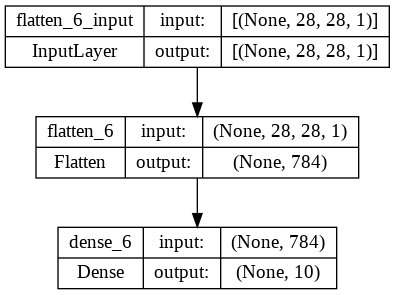

In [55]:
IPython.display.Image( plotFile) 

# Model: One Convolutional Layer (32 filters)

Epoch 1/20
465/469 [============================>.] - ETA: 0s - loss: 5.4235 - acc: 0.8274

469/469 [==============================] - 3s 6ms/step - loss: 5.3832 - acc: 0.8278 - val_loss: 0.3823 - val_acc: 0.8731
Epoch 2/20
459/469 [============================>.] - ETA: 0s - loss: 0.3058 - acc: 0.8946

469/469 [==============================] - 3s 6ms/step - loss: 0.3051 - acc: 0.8950 - val_loss: 0.3678 - val_acc: 0.8824
Epoch 3/20
461/469 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9068

469/469 [==============================] - 3s 6ms/step - loss: 0.2692 - acc: 0.9064 - val_loss: 0.3709 - val_acc: 0.8825
Epoch 4/20
462/469 [============================>.] - ETA: 0s - loss: 0.2495 - acc: 0.9135

469/469 [==============================] - 3s 6ms/step - loss: 0.2496 - acc: 0.9133 - val_loss: 0.3712 - val_acc: 0.8856
Test loss: 0.3677825927734375
Test accuracy: 0.8823999762535095


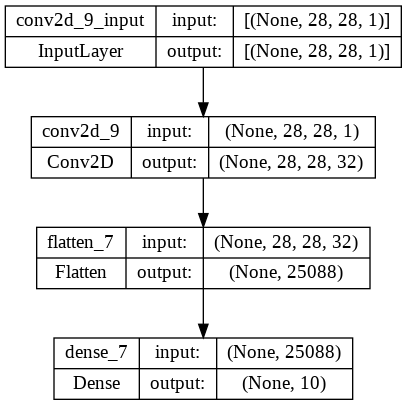

In [56]:
mnist_conv1_model = createModel(input_shape, num_filters=[32], num_classes=num_classes)
modelName="mnist_conv1"

acc, plotFile = trainModel(mnist_conv1_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

# Model: 2 Convolutional Layers (32, 64 filters)

Adding Conv block with 64 filters
Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 1.3229 - acc: 0.8488

469/469 [==============================] - 8s 15ms/step - loss: 1.3229 - acc: 0.8488 - val_loss: 0.3633 - val_acc: 0.8778
Epoch 2/20
467/469 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.8910

469/469 [==============================] - 6s 13ms/step - loss: 0.3148 - acc: 0.8909 - val_loss: 0.4323 - val_acc: 0.8596
Epoch 3/20
467/469 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.8978

469/469 [==============================] - 7s 14ms/step - loss: 0.2947 - acc: 0.8976 - val_loss: 0.3941 - val_acc: 0.8719
Test loss: 0.3633345067501068
Test accuracy: 0.8777999877929688


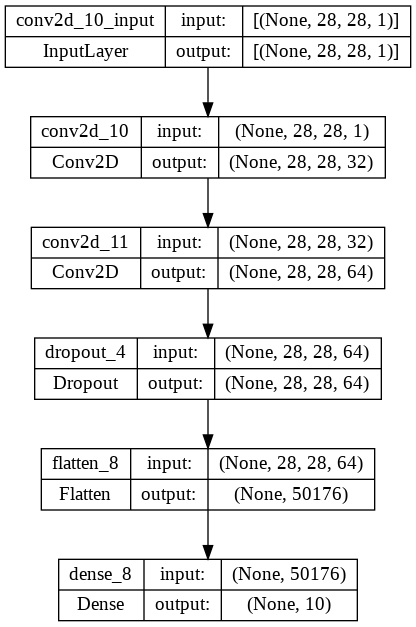

In [57]:
mnist_conv2_model = createModel(input_shape, num_filters=[32, 64], num_classes=num_classes)
modelName="mnist_conv2"

acc, plotFile = trainModel(mnist_conv2_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

# Model: 2 Convolutional Layers (8, 16 filters, no pooling)

Adding Conv block with 16 filters
Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 1.9715 - acc: 0.8262

469/469 [==============================] - 4s 7ms/step - loss: 1.9715 - acc: 0.8262 - val_loss: 0.3792 - val_acc: 0.8702
Epoch 2/20
464/469 [============================>.] - ETA: 0s - loss: 0.3472 - acc: 0.8795

469/469 [==============================] - 3s 6ms/step - loss: 0.3475 - acc: 0.8796 - val_loss: 0.3718 - val_acc: 0.8705
Epoch 3/20
465/469 [============================>.] - ETA: 0s - loss: 0.3259 - acc: 0.8881

469/469 [==============================] - 3s 6ms/step - loss: 0.3256 - acc: 0.8881 - val_loss: 0.3938 - val_acc: 0.8694
Epoch 4/20
468/469 [============================>.] - ETA: 0s - loss: 0.3104 - acc: 0.8918

469/469 [==============================] - 3s 7ms/step - loss: 0.3103 - acc: 0.8918 - val_loss: 0.3619 - val_acc: 0.8775
Epoch 5/20
463/469 [============================>.] - ETA: 0s - loss: 0.3018 - acc: 0.8946

469/469 [==============================] - 3s 7ms/step - loss: 0.3019 - acc: 0.8946 - val_loss: 0.3602 - val_acc: 0.8756
Epoch 6/20
466/469 [============================>.] - ETA: 0s - loss: 0.2963 - acc: 0.8984

469/469 [==============================] - 3s 7ms/step - loss: 0.2960 - acc: 0.8984 - val_loss: 0.3755 - val_acc: 0.8768
Test loss: 0.3618728816509247
Test accuracy: 0.8774999976158142


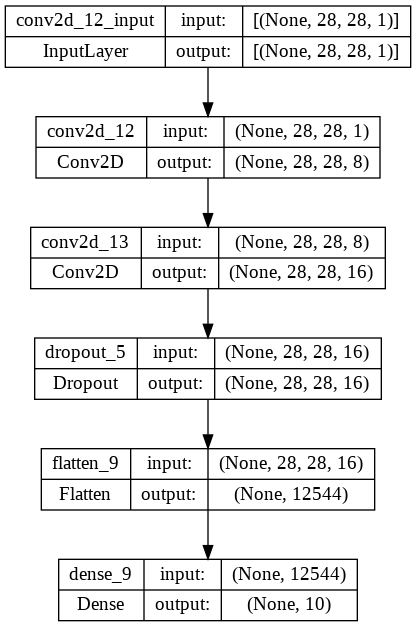

In [58]:
mnist_conv2_8_16_model = createModel(input_shape, num_filters=[8, 16], num_classes=num_classes)
modelName="mnist_conv2_8_16"

acc, plotFile = trainModel(mnist_conv2_8_16_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 


## Count the parameters

In [59]:
mnist_conv2_8_16_model.count_params()

126698

# Model: 2 Convolutional Layers (8, 16 filters, pooling)

Adding Pool + Conv block with 16 filters
Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 2.1367 - acc: 0.7865

469/469 [==============================] - 4s 7ms/step - loss: 2.1367 - acc: 0.7865 - val_loss: 0.4091 - val_acc: 0.8576
Epoch 2/20
468/469 [============================>.] - ETA: 0s - loss: 0.3833 - acc: 0.8665

469/469 [==============================] - 3s 6ms/step - loss: 0.3834 - acc: 0.8664 - val_loss: 0.3915 - val_acc: 0.8676
Epoch 3/20
458/469 [============================>.] - ETA: 0s - loss: 0.3563 - acc: 0.8757

469/469 [==============================] - 3s 6ms/step - loss: 0.3557 - acc: 0.8759 - val_loss: 0.3696 - val_acc: 0.8785
Epoch 4/20
458/469 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.8804

469/469 [==============================] - 3s 6ms/step - loss: 0.3420 - acc: 0.8802 - val_loss: 0.3676 - val_acc: 0.8730
Epoch 5/20
467/469 [============================>.] - ETA: 0s - loss: 0.3334 - acc: 0.8831

469/469 [==============================] - 3s 6ms/step - loss: 0.3335 - acc: 0.8831 - val_loss: 0.3661 - val_acc: 0.8766
Test loss: 0.3696286976337433
Test accuracy: 0.8784999847412109


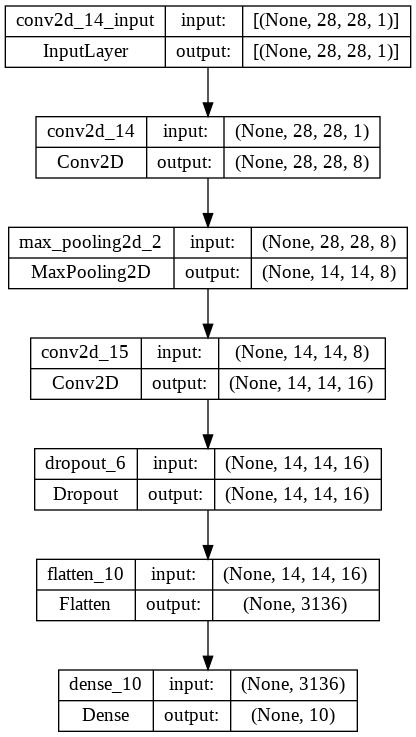

In [60]:
mnist_conv2_8_16_pool_model = createModel(input_shape, num_filters=[8, 16], pool=[False, True], num_classes=num_classes)
modelName="mnist_conv2_8_16_pool"

acc, plotFile = trainModel(mnist_conv2_8_16_pool_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

## Count the parameters

In [61]:
mnist_conv2_8_16_pool_model.count_params()

32618

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 1.3420 - acc: 0.7958

469/469 [==============================] - 4s 7ms/step - loss: 1.3420 - acc: 0.7958 - val_loss: 0.4170 - val_acc: 0.8531
Epoch 2/20
468/469 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8632

469/469 [==============================] - 3s 6ms/step - loss: 0.3885 - acc: 0.8633 - val_loss: 0.3991 - val_acc: 0.8605
Epoch 3/20
468/469 [============================>.] - ETA: 0s - loss: 0.3530 - acc: 0.8763

469/469 [==============================] - 3s 7ms/step - loss: 0.3528 - acc: 0.8763 - val_loss: 0.4120 - val_acc: 0.8610
Epoch 4/20
463/469 [============================>.] - ETA: 0s - loss: 0.3314 - acc: 0.8842

469/469 [==============================] - 3s 6ms/step - loss: 0.3321 - acc: 0.8840 - val_loss: 0.3709 - val_acc: 0.8758
Epoch 5/20
461/469 [============================>.] - ETA: 0s - loss: 0.3212 - acc: 0.8872

469/469 [==============================] - 3s 6ms/step - loss: 0.3208 - acc: 0.8873 - val_loss: 0.3664 - val_acc: 0.8784
Epoch 6/20
463/469 [============================>.] - ETA: 0s - loss: 0.3122 - acc: 0.8918

469/469 [==============================] - 3s 6ms/step - loss: 0.3124 - acc: 0.8916 - val_loss: 0.3797 - val_acc: 0.8711
Test loss: 0.3708680272102356
Test accuracy: 0.8758000135421753


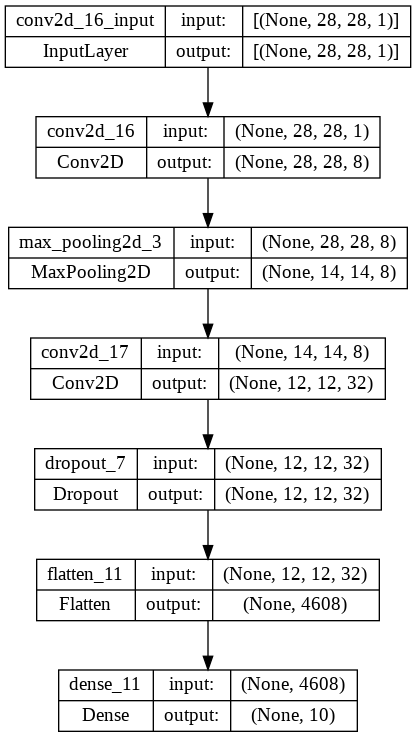

In [62]:
def createModelSeq():
  model = Sequential( [ 
                       Conv2D(8, kernel_size=(3, 3),
                              activation='relu',
                              input_shape=input_shape,
                              padding="same"),
                       MaxPooling2D(pool_size=(2, 2)),
                       Conv2D(32, (3, 3), activation='relu'),
                       #MaxPooling2D(pool_size=(2, 2)),
                       #Conv2D(128, (3, 3), activation='relu'),
                       Dropout(0.25),
                       Flatten(),
                       #Dense(128, activation='relu'),
                       #Dropout(0.5),
                       Dense(num_classes, activation='softmax')
  ]
)

  return model

modelName="mnist_conv_seq"

mnist_seq_model = createModelSeq()
acc, plotFile = trainModel(mnist_seq_model, modelName, X_train, y_train, X_test, y_test)
IPython.display.Image( plotFile) 

In [63]:
mnist_seq_model.count_params()

48506

In [64]:
model_vis = mnist_seq_model
model_vis = mnist_conv2_model
layer_dict = dict([(layer.name, layer) for layer in model_vis.layers[0:]])
layer_dict.keys()

dict_keys(['conv2d_10', 'conv2d_11', 'dropout_4', 'flatten_8', 'dense_8'])

# CNN Filter Visualization

Derived from Keras examples https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb

In [65]:
# Set up a model that returns the activation values for our target layer

img_width, img_height, img_channels=X_train[0].shape


In [66]:
# Create a feature extractor

def create_feature_extractor(model, layer_name):
  """
  Create a feature extractor

  Parameters
  ----------
  model: Keras Model object
  layer_name: String.  Name of a layer in model

  Returns
  -------
  function: () => output of layer

    function takes no arguments, returns the outputs (feature maps) of layer layer_name
  """
  
  layer = model.get_layer(name=layer_name)
  feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

  return feature_extractor

In [67]:
def compute_loss(input_image, feature_extractor, filter_index):
  """
  Return the average (across spatial dimension) of the values of the features
   in a single feature map

  Parameters
  -----------
  feature_extractor: a feature_extractor created by create_feature_extractor
  filter_index: index of one feature map in the feature maps returned by the feature_extractor

  Returns
  -------
  Average feature value
  """

  activation = feature_extractor(input_image)
  # We avoid border artifacts by only involving non-border pixels in the loss.
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
 
  return tf.reduce_mean(filter_activation)


In [68]:
@tf.function
def gradient_ascent_step(img, feature_extractor, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, feature_extractor, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [69]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, img_channels))

    return img 


def visualize_filter(feature_extractor, filter_index, deprocess=True):
    # We run gradient ascent for 20 steps
    iterations = 50
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, feature_extractor, filter_index, learning_rate)
   
    # Decode the resulting input image
    if deprocess:
      img = deprocess_image(img[0].numpy())
    else:
      img = img[0].numpy()
    return loss, img


def deprocess_image(img):
    print("Deprocess: input shape=", img.shape)
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    print("Deprocess stdize: output shape=", img.shape)  
    # Center crop
    img_width, img_height, img_channels=img.shape
    fraction=.1
    img = img[ int(fraction*img_width):int((1-fraction)*img_width), int(fraction*img_height):int((1-fraction)*img_height),:]
    # img = img[25:-25, 25:-25, :]

    print("Deprocess remove edge: output shape=", img.shape)  
    
    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")

    print("Deprocess: output shape=", img.shape)
    return img

## Utility routines for visualization

In [70]:
import regex as re

def visualize_layer(model, layer_name,
                    filter_range=(0,None),
                    deprocess=False
                    ):
  """
  Visualizes the most relevant filters of one conv-layer in a certain model.

  Parameters
  -----------
  model: A model
  layer_name: String.  Name of a Convolutional layer to be visualized
  filter_range: Tuple(index_low, index_hi)
      Only show features with index between index_low and index_hi
  """

  # Create a feature extractor for the layer      
  feature_extractor = create_feature_extractor(model_vis, layer_name)

  # How many features in this layer ?
  # Determine from the layer's weights
  # weights[1] is the number of biases, hence the number of features
  num_features = len(model.get_layer(name=layer_name).get_weights()[1])

  print("Layer {l:s} has {n:d} features".format(l=layer_name, n=num_features))

  # Determine the indices of the filters to visualize
  (index_low, index_hi) = filter_range
  if index_hi is None:
    index_hi = num_features

  # Visualize the features
  imgs = {}

  for feature_idx in range(index_low, index_hi):
    loss, img = visualize_filter(feature_extractor, feature_idx, deprocess=False)

    imgs[feature_idx] = img

  num_to_show = (index_hi-1) - index_low +1
  num_per_row = 8
  num_rows = int(num_to_show/num_per_row + 0.5)

  fig, axs=plt.subplots(num_rows, num_per_row, figsize=(12,3*num_rows))
  if len(axs.shape) == 1:
    axs = axs[ np.newaxis, :]

  fig.suptitle("Layer {l:s}".format(l=layer_name), fontsize=14, fontweight="bold")
  feature_idxs = sorted( imgs )

  for i, idx in enumerate(feature_idxs):
    ax = axs[ i // num_per_row, i % num_per_row]
    img = imgs[idx]
    showImage(img, ax=ax, title="Feature {i:d}".format(i=idx) )


def visualize_layers(model, layer_names=None,
                    filter_range=(0,None),
                    deprocess=False
                    ):  
  """
  Visualizes the most relevant filters of the conv-layers in a certain model.

  Parameters
  -----------
  model: A model
  layer_names: Array of String.  Names of a Convolutional layer to be visualized
  filter_range: Tuple(index_low, index_hi)
      Only show features with index between index_low and index_hi
  """   

  if layer_names is None:
    # Find the Convolutional layers, assuming names contain "conv"
    layer_names = []
    layers = model.layers
    
    for layer in layers:
      layer_name = layer.name

      if re.search("conv", layer_name) is not None:
        layer_names.append(layer_name)


  for layer_name in layer_names:       
    visualize_layer(model, layer_name, filter_range=filter_range)
 


## Visualize the convolution layers of a model

Layer conv2d_10 has 32 features
Layer conv2d_11 has 64 features


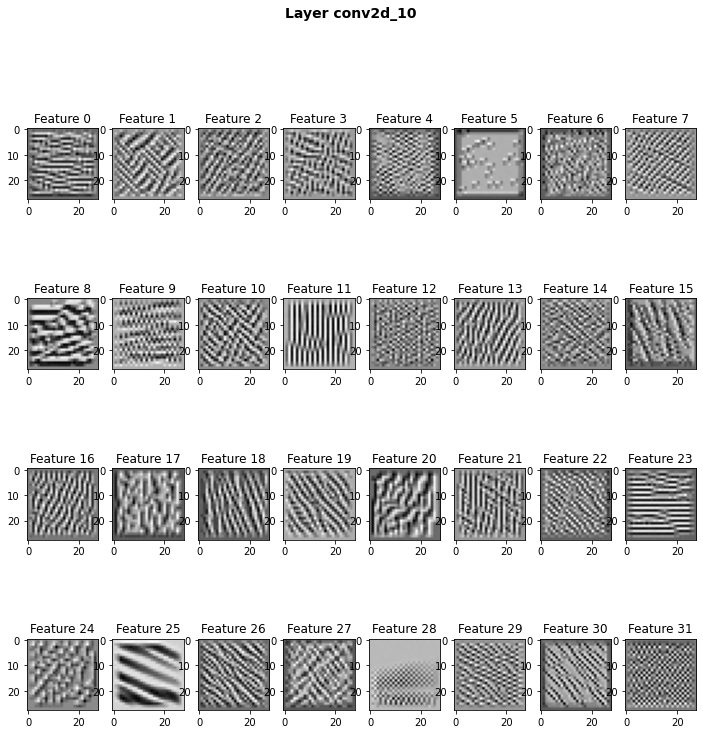

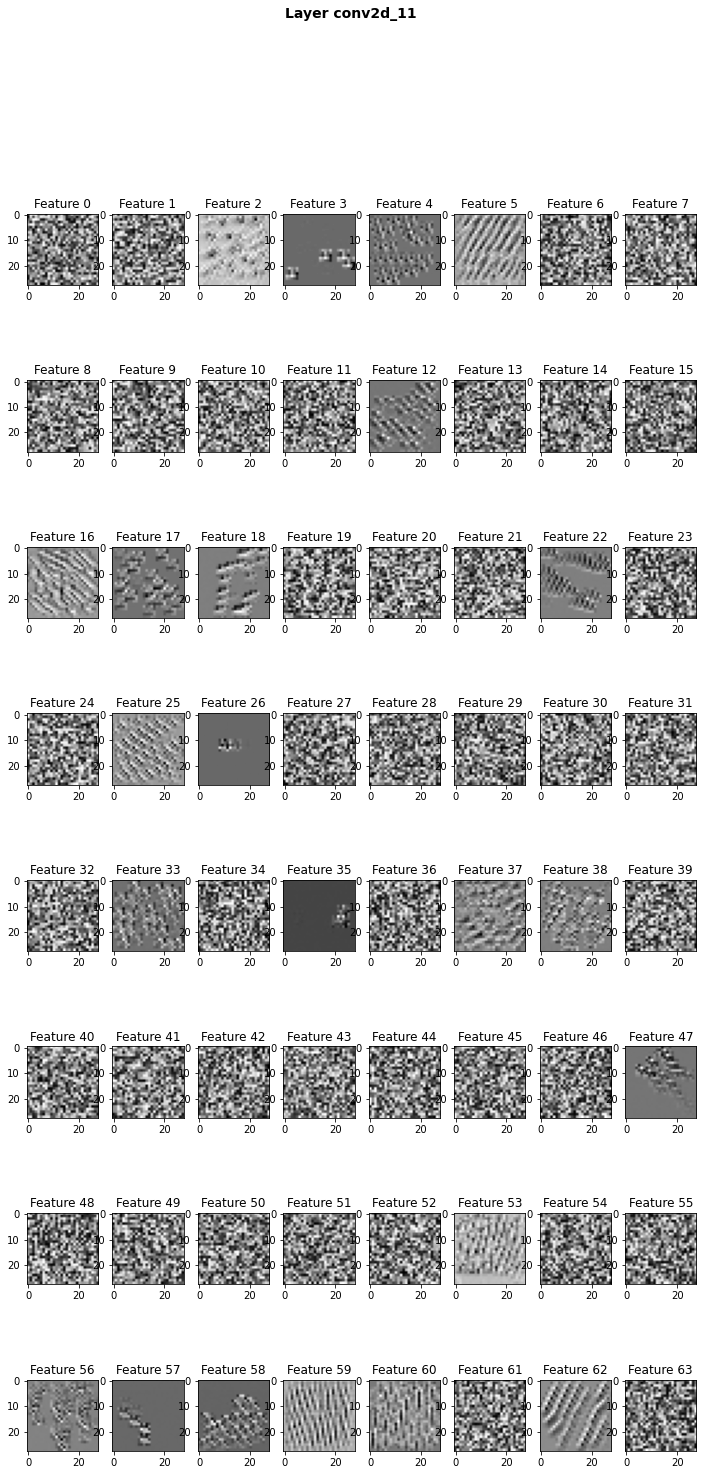

In [71]:
visualize_layers(model_vis)


# CNN Filter Visualization (OBSOLETE after TensorFlow version < 2)

Derived from Keras examples https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py

In [72]:

if tf_major <2:
  vis_conv_model(mnist_conv2_8_16_model)
else:
  print("This code is obsolete after version 1 of TensorFlow and is retained only for historic reference. \nRefer to the above code instead.")



This code is obsolete after version 1 of TensorFlow and is retained only for historic reference. 
Refer to the above code instead.


In [73]:
assert tf_major < 2

AssertionError: ignored

In [ ]:
"""
#Visualization of the filters of VGG16, via gradient ascent in input space.

This script can run on CPU in a few minutes.

Results example: ![Visualization](http://i.imgur.com/4nj4KjN.jpg)
"""
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

import pdb


In [ ]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(x))) + tf.keras.backend.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + tf.keras.backend.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if tf.keras.backend.image_data_format() == 'channels_first':
            loss = tf.keras.backend.mean(layer_output[:, filter_index, :, :])
        else:
            loss = tf.keras.backend.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = tf.keras.backend.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = tf.keras.backend.function([input_img], [loss, grads])

        
        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if tf.keras.backend.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, kjp_channels, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], kjp_channels))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        stitch = False
        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= tf.keras.backend.epsilon():
                    return None


        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]     

    # kjp added
    kjp_channels = 1 # 3
    
    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

    return processed_filters




In [ ]:
tf.keras.backend.set_learning_phase(0)

import matplotlib as mpl
import math

def plotFilters(pfilters):
  fig = plt.figure(figsize=(max( math.ceil(len(pfilters)/6) * 3, 12),15))

  # Sort the filters
  pfilters.sort(key=lambda x: x[1], reverse=True)


  i = 0
  for filter, loss in pfilters:
    ax = fig.add_subplot( math.ceil(len(pfilters)/6), 6, i+1)
    
    ax.imshow(filter.reshape(28,28), cmap=mpl.cm.binary)
    i += 1

  return fig


def vis_conv_model(model_vis):
  conv_layers = [ layer.name  for layer in model_vis.layers if isinstance(layer, layers.Conv2D) ]

  pfilters = {}
  for conv_layer in conv_layers:
    print("Computing filters for ", conv_layer)
    pfilters[conv_layer] = visualize_layer(model_vis, conv_layer, output_dim=(28,28), upscaling_steps=1, upscaling_factor=1.)

  for conv_layer in conv_layers:
    print("Plotting filters for ", conv_layer)
    fig = plotFilters( pfilters[conv_layer] )
    fig.suptitle(conv_layer, size=16)